In [1]:
%load_ext autoreload
%autoreload 2

# TODO -> remove unused imports
import sys

import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
)
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

sys.path.append("..")
from GSSP_utils.data_filtering import (
    _noisy_recording_mask,
    _silent_recording_mask,
    _silent_end_mask,
    _skip_id_mask,
    get_valid_audio_mask,
    id_vars_set,
)
from GSSP_utils.path_conf import loc_data_dir
from GSSP_utils.visualizations import plot_linear_classification_coefs

## `Within dataset`: Speech web app data

In [2]:
# ------ Configure these parameters ------
DUR_S = 15
start = False

feat_path = loc_data_dir.joinpath(
    f"df_gemaps_{DUR_S}s_{'start' if start else 'end'}.parquet"
)

display(feat_path)
df_feat_tot = pd.read_parquet(feat_path, engine="fastparquet")
df_session = pd.read_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned_VAD.parquet")
)
print("df_feat_tot", df_feat_tot.shape)
print("df_session", df_session.shape)

# and merge the data
df_session_feat = df_feat_tot.merge(
    df_session, on=["ID", "DB", "pic_name", "time_str"], how="left"
)
del feat_path, df_session, df_feat_tot

# add a speech_style column to df_session_feat
df_session_feat["speech_style"] = df_session_feat.DB.map(
    lambda x: {"marloes": "Read", "PiSCES": "GSSP", "Radboud": "GSSP"}.get(x)
)

# mask for valid audio
df_session_feat = (
    df_session_feat[
        get_valid_audio_mask(df_session_feat) & ~_silent_end_mask(df_session_feat)
    ]
    .copy()
    .reset_index(drop=True)
)
print("df_session_feat masked", df_session_feat.shape)
df_session_feat.head(3)

PosixPath('/home/jonas/git/github/semi-guided-speech/notebooks/../loc_data/df_gemaps_15s_end.parquet')

df_feat_tot (2909, 69)
df_session (3257, 25)
df_session_feat masked (2901, 91)


,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,wav_timestamp,arousal,valence,DB_no,session_no,pic_no,VAD_sliced_duration_s,VAD_speech_start_s,VAD_speech_end_s,speech_style
0,/media/SPS/interim/speech_webapp/VAD_slice_16k...,0 days 00:00:07.619937,0 days 00:00:22.619937,33.850227,0.105944,33.023087,33.945721,36.165443,3.142357,156.227295,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Read
1,/media/SPS/interim/speech_webapp/VAD_slice_16k...,0 days 00:00:27.119875,0 days 00:00:42.119875,34.144611,0.121281,33.325859,34.103828,36.804985,3.479126,154.825546,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSSP
2,/media/SPS/interim/speech_webapp/VAD_slice_16k...,0 days 00:00:45.249875,0 days 00:01:00.249875,32.017315,0.128480,32.623184,33.263153,34.016792,1.393608,506.733612,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GSSP


Construct the `X` matrix and `y` vector

In [3]:
X = df_session_feat.drop(
    columns=list(id_vars_set())
    + ["speech_style_pred"]
    + ["F0semitoneFrom27.5Hz_sma3nz_nzcount", "F0final_sma_nzcount"],
    errors="ignore",
)
y = df_session_feat["speech_style"]

# assert that there are no Nans
nan_mask = X.isna().any(axis=1)
assert nan_mask.sum() == 0, "There are NaNs in the data"

groups = df_session_feat["ID"].values
x_cols = X.columns

/tmp/ipykernel_1293363/804735913.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  X_.columns = X_.columns.str.replace("F0semitoneFrom27.5Hz", "F0st").str.replace("F1amplitude", "F1amp")


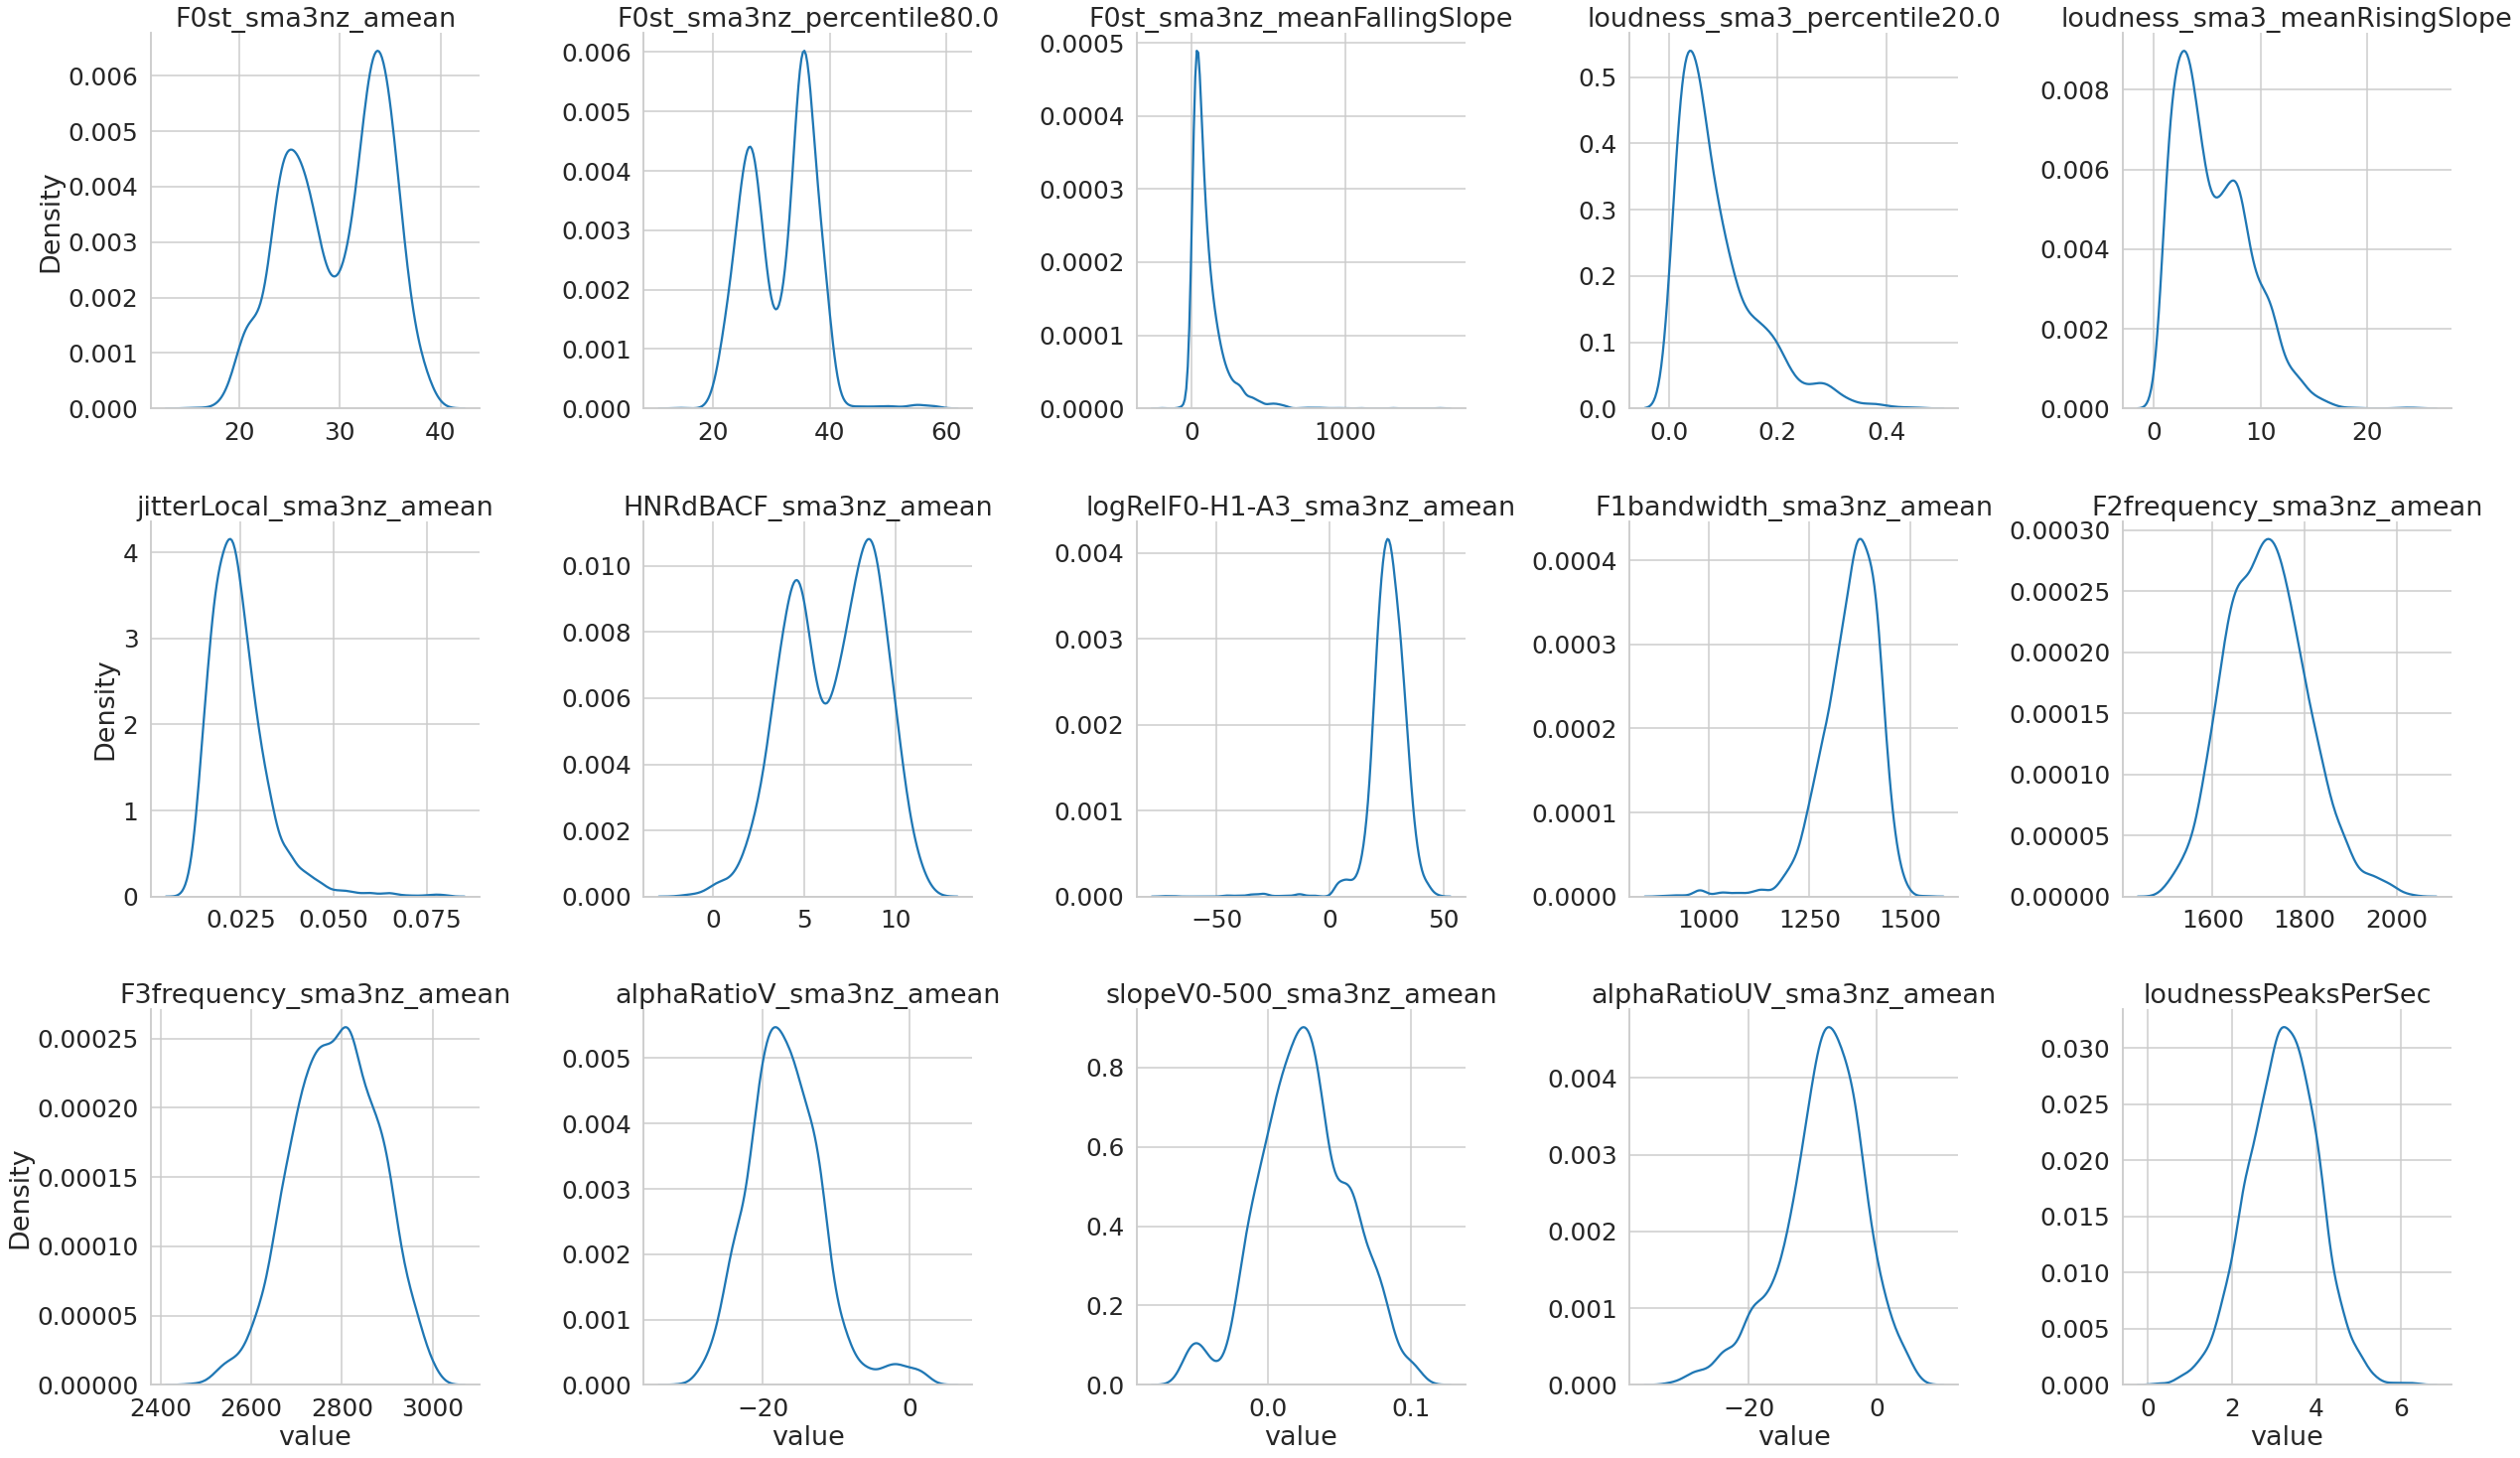

In [4]:
sns.set_context("talk", font_scale=1.5)
X_ = X.copy()
X_.columns = X_.columns.str.replace("F0semitoneFrom27.5Hz", "F0st").str.replace(
    "F1amplitude", "F1amp"
)
g = sns.displot(
    data=X_.iloc[:, ::4].iloc[:, :15].melt(),
    col="variable",
    x="value",
    col_wrap=5,
    height=7,
    facet_kws={"sharex": False, "sharey": False},
    kind="kde",
)
g.set_titles("{col_name}")
plt.subplots_adjust(hspace=0.3, wspace=0.5)

In [6]:
# Model 1: Random Forest
# model = Pipeline(
#     [
#         (
#             "rf",
#             RandomForestClassifier(
#                 class_weight="balanced",
#                 n_estimators=200,
#                 min_samples_split=25,
#                 min_samples_leaf=10,
#                 max_depth=3,
#             ),
#         ),
#     ]
# )

# cvs = cross_val_score(
#     estimator=model,
#     X=X,
#     y=y,
#     scoring="balanced_accuracy",
#     cv=StratifiedGroupKFold(n_splits=5),
#     groups=groups,
# )

# print("random forest:")
# print(cvs.round(3))
# print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")

from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------------------------
# Model 2: Logistic Regression
model = Pipeline(
    [
        # ("scaling", PowerTransformer()),
        ("scaling", StandardScaler()),
        ("lr", LogisticRegression(C=0.05, max_iter=200, class_weight="balanced")),
    ]
)

cvs = cross_val_score(
    estimator=model,
    X=X,
    y=y,
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=groups,
)
print("\nlogistic regression:")
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


logistic regression:
[0.784 0.8   0.887 0.816 0.827]
0.823±0.035


              precision    recall  f1-score   support

        GSSP       0.91      0.89      0.90       784
        Read       0.57      0.62      0.59       184

    accuracy                           0.84       968
   macro avg       0.74      0.75      0.75       968
weighted avg       0.84      0.84      0.84       968



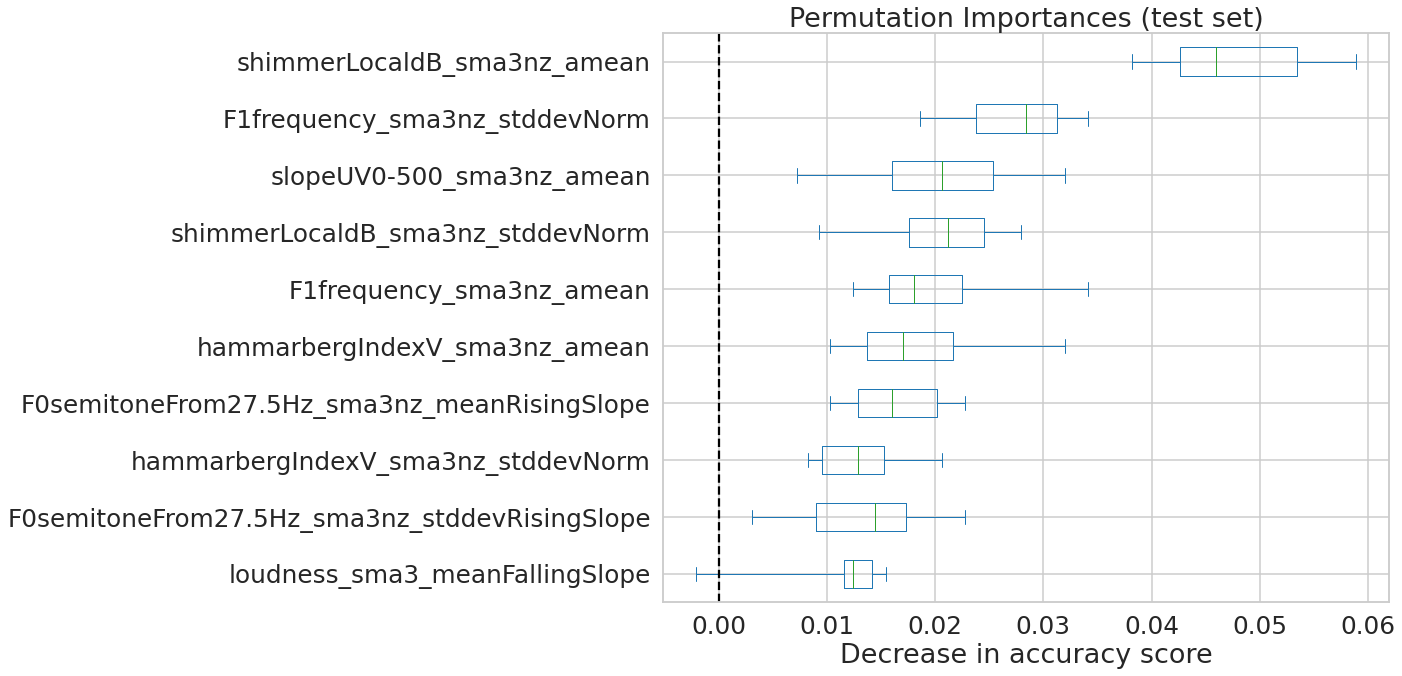

              precision    recall  f1-score   support

        GSSP       0.97      0.72      0.83       766
        Read       0.45      0.92      0.60       186

    accuracy                           0.76       952
   macro avg       0.71      0.82      0.72       952
weighted avg       0.87      0.76      0.79       952



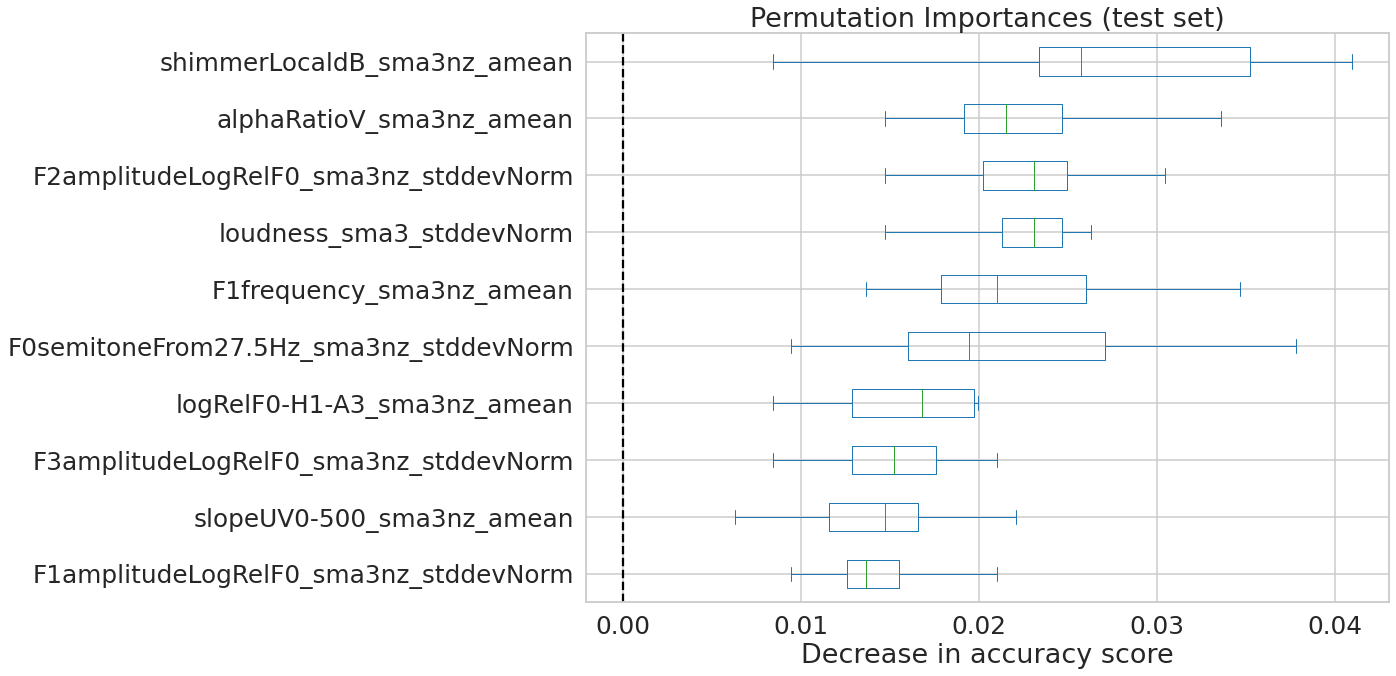

              precision    recall  f1-score   support

        GSSP       0.98      0.76      0.85       797
        Read       0.47      0.92      0.62       184

    accuracy                           0.79       981
   macro avg       0.72      0.84      0.74       981
weighted avg       0.88      0.79      0.81       981



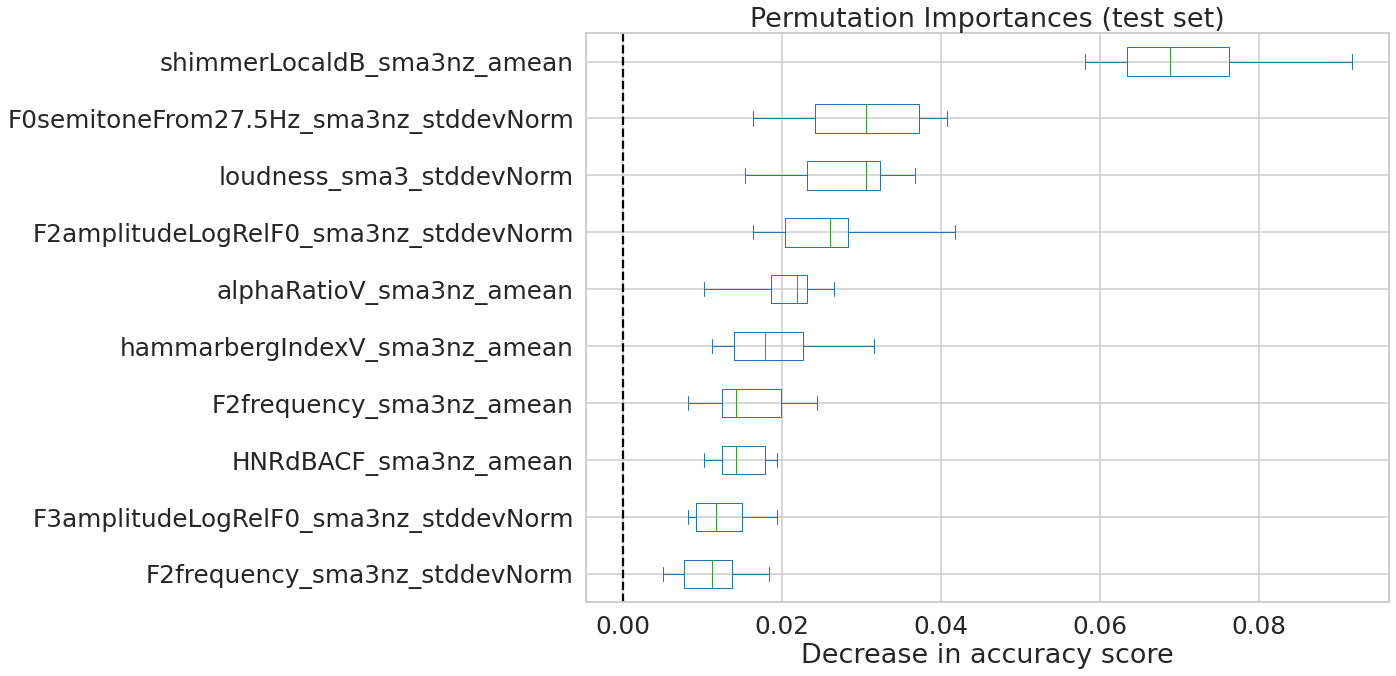

In [7]:
kf = StratifiedGroupKFold(n_splits=3)
for train_idx, test_idx in kf.split(X, y=y, groups=groups):
    x_train_ = X.iloc[train_idx, :][x_cols]
    x_test_cv_ = X.iloc[test_idx, :][x_cols]
    model = model.fit(x_train_, y[train_idx])
    preds = model.predict(x_test_cv_)
    print(classification_report(y[test_idx], preds))

    r = permutation_importance(
        model, x_test_cv_, y[test_idx], n_repeats=10, random_state=0, n_jobs=2
    )
    r = permutation_importance(
        model, x_test_cv_, y[test_idx], n_repeats=10, random_state=0, n_jobs=2
    )

    sorted_importances_idx = r.importances_mean.argsort()
    importances = pd.DataFrame(
        r.importances[sorted_importances_idx].T,
        columns=np.array(x_cols)[sorted_importances_idx],
    )

    fig, ax = plt.subplots(figsize=(20, 10))
    importances.iloc[:, -10:].plot.box(vert=False, whis=10, ax=ax)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

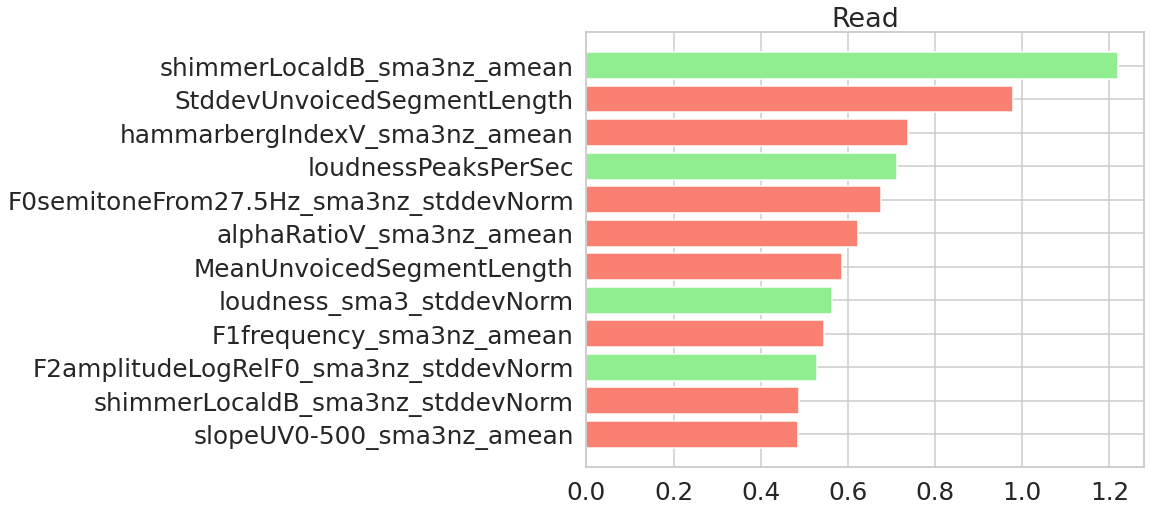

In [22]:
plot_linear_classification_coefs(model, feat_cols=X.columns, nb_to_show=12)

In [23]:
# model.fit(X, y)
# plot_linear_classification_coefs(model, feat_cols=X.columns, nb_to_show=12)

## `External`: train on Speech web app; validate on CGN data

In [2]:
end = True
suffix = "_end" if end else ""

# Load in the GEMAPS CGN data
df_gemaps_cgn = pd.read_parquet(
    loc_data_dir / f"df_gemaps_cgn_15s{suffix}.parquet", engine="fastparquet"
)

df_gemaps_cgn["speech_style"] = df_gemaps_cgn["dop"].map(
    lambda x: {"scripted": "Read", "unscripted": "GSSP"}.get(x)
)

df_gemaps_cgn = df_gemaps_cgn[
    ~df_gemaps_cgn.speaker_name.isin(["BACKGROUND", "COMMENT"])
]

In [3]:
display(df_gemaps_cgn.shape)
display(df_gemaps_cgn.groupby("speech_style").size().rename("#samples").to_frame())

(3357, 126)

,#samples
speech_style,
GSSP,1714
Read,1643


In [11]:
df_gemaps_cgn.drop_duplicates(subset="speaker_name").sex.value_counts()

female    163
male      138
Name: sex, dtype: int64

In [9]:
# df_gemaps_cgn["speaker_name"].nunique()

301

In [8]:
df_gemaps_cgn.groupby("component")["speaker_name"].nunique()

component
b    114
o    187
Name: speaker_name, dtype: int64

In [10]:
use_rf = False
show_kfold = False

if use_rf:
    model = Pipeline(
        [
            (
                "rf",
                RandomForestClassifier(
                    class_weight="balanced",
                    n_estimators=200,
                    min_samples_split=25,
                    min_samples_leaf=10,
                    max_depth=3,
                ),
            ),
        ]
    )
else:
    model = Pipeline(
        [
            ("scaling", PowerTransformer()),
            # ("scaling", StandardScaler()),
            ("lr", LogisticRegression(C=0.15, max_iter=200, class_weight="balanced")),
        ]
    )

# x_cols = X.columns
x_cols = [
    # "F0semitoneFrom27.5Hz_sma3nz_amean",
    "F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2",
    "F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope",
    "F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope",
    "F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope",
    "F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope",
    # "loudness_sma3_amean",
    "loudness_sma3_stddevNorm",
    "loudness_sma3_pctlrange0-2",
    "loudness_sma3_meanRisingSlope",
    "loudness_sma3_stddevRisingSlope",
    "loudness_sma3_meanFallingSlope",
    "loudness_sma3_stddevFallingSlope",
    "jitterLocal_sma3nz_amean",
    "jitterLocal_sma3nz_stddevNorm",
    "shimmerLocaldB_sma3nz_amean",
    "shimmerLocaldB_sma3nz_stddevNorm",
    "HNRdBACF_sma3nz_amean",
    "HNRdBACF_sma3nz_stddevNorm",
    "loudnessPeaksPerSec",
    "VoicedSegmentsPerSec",
    "MeanVoicedSegmentLengthSec",
    "StddevVoicedSegmentLengthSec",
    "MeanUnvoicedSegmentLength",
    "StddevUnvoicedSegmentLength",
    # "logRelF0-H1-H2_sma3nz_amean",
    # "logRelF0-H1-H2_sma3nz_stddevNorm",
    # "logRelF0-H1-A3_sma3nz_amean",
    # "logRelF0-H1-A3_sma3nz_stddevNorm",
    # "F1frequency_sma3nz_amean",
    # "F1frequency_sma3nz_stddevNorm",
    # "F1bandwidth_sma3nz_amean",
    # "F1bandwidth_sma3nz_stddevNorm",
]

In [11]:
# fit the model on the speech web app experiment data
print("-" * 80)
print("Train set: SPS web app data")
cvs = cross_val_score(
    estimator=model,
    X=X[x_cols],
    y=y,
    scoring="balanced_accuracy",
    cv=StratifiedGroupKFold(n_splits=5),
    groups=groups,
)
print(cvs.round(3))
print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")


if show_kfold:
    kf = StratifiedGroupKFold(n_splits=3)
    for train_idx, test_idx in kf.split(X, y=y, groups=groups):
        x_train_ = X.iloc[train_idx, :][x_cols]
        x_test_cv_ = X.iloc[test_idx, :][x_cols]
        model = model.fit(x_train_, y[train_idx])
        preds = model.predict(x_test_cv_)
        print(classification_report(y[test_idx], preds))

        r = permutation_importance(
            model, x_test_cv_, y[test_idx], n_repeats=10, random_state=0, n_jobs=2
        )

        sorted_importances_idx = r.importances_mean.argsort()
        importances = pd.DataFrame(
            r.importances[sorted_importances_idx].T,
            columns=np.array(x_cols)[sorted_importances_idx],
        )

        fig, ax = plt.subplots(figsize=(10, 10))
        importances.iloc[:, -10:].plot.box(vert=False, whis=10, ax=ax)
        ax.set_title("Permutation Importances (test set)")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()
        plt.show()


# fit the model on the whole SPS data and validate on the CGN data
model.fit(X[x_cols], y)
predictions = model.predict(df_gemaps_cgn[x_cols])
print(classification_report(df_gemaps_cgn["speech_style"], predictions))
print(
    "balanced acc:", balanced_accuracy_score(df_gemaps_cgn["speech_style"], predictions)
)

if False:
    # --------------------------------------------------------------------------------
    # fit the model on the CGN gemaps data
    # print("-" * 80)
    # print("Train set: CGN")
    # cvs = cross_val_score(
    #     estimator=model,
    #     X=df_gemaps_cgn[x_cols],
    #     y=df_gemaps_cgn["speech_style"],
    #     scoring="balanced_accuracy",
    #     cv=StratifiedGroupKFold(n_splits=5),
    #     groups=df_gemaps_cgn["speaker_name"].values,
    # )
    # print(cvs.round(3))
    # print(f"{cvs.mean().round(3)}±{cvs.std().round(3)}")

    # if show_kfold:
    #     kf = StratifiedGroupKFold(n_splits=3)
    #     for train_idx, test_idx in kf.split(
    #         df_gemaps_cgn[x_cols],
    #         y=df_gemaps_cgn["speech_style"],
    #         groups=df_gemaps_cgn["speaker_name"].values,
    #     ):
    #         x_train_ = df_gemaps_cgn.iloc[train_idx, :][x_cols]
    #         x_test_cv_ = df_gemaps_cgn.iloc[test_idx, :][x_cols]
    #         y_train_ = df_gemaps_cgn.iloc[train_idx, :]["speech_style"]
    #         y_test = df_gemaps_cgn.iloc[test_idx, :]["speech_style"]
    #         model = model.fit(x_train_, y_train_)
    #         preds = model.predict(x_test_cv_)
    #         print(classification_report(y_test, preds))

    #         r = permutation_importance(
    #             model, x_test_cv_, y_test, n_repeats=10, random_state=0, n_jobs=2
    #         )

    #         sorted_importances_idx = r.importances_mean.argsort()
    #         importances = pd.DataFrame(
    #             r.importances[sorted_importances_idx].t,
    #             columns=x_cols[sorted_importances_idx],
    #         )

    #         fig, ax = plt.subplots(figsize=(10, 10))
    #         importances.iloc[:, -10:].plot.box(vert=false, whis=10, ax=ax)
    #         ax.set_title("permutation importances (test set)")
    #         ax.axvline(x=0, color="k", linestyle="--")
    #         ax.set_xlabel("decrease in accuracy score")
    #         ax.figure.tight_layout()
    #         plt.show()

    # model.fit(df_gemaps_cgn[x_cols], df_gemaps_cgn["speech_style"])
    # predictions = model.predict(X[x_cols])
    # print(classification_report(y, predictions))
    pass

--------------------------------------------------------------------------------
Train set: SPS web app data


/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jonas/.cache/p

[0.792 0.788 0.853 0.785 0.825]
0.809±0.027
              precision    recall  f1-score   support

        GSSP       0.80      0.54      0.64      1714
        Read       0.64      0.86      0.73      1643

    accuracy                           0.70      3357
   macro avg       0.72      0.70      0.69      3357
weighted avg       0.72      0.70      0.69      3357

balanced acc: 0.6986380464912136


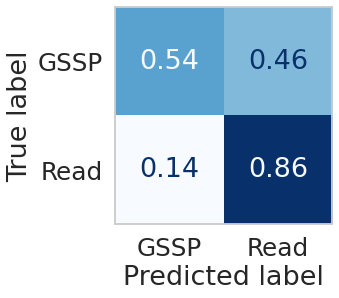

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_gemaps_cgn["speech_style"], predictions)

# fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_estimator(
    model,
    df_gemaps_cgn[x_cols],
    df_gemaps_cgn["speech_style"],
    display_labels=model.classes_,
    normalize="true",
    cmap=plt.cm.Blues,
    colorbar=False,
)
# make the image transparent
disp.ax_.patch.set_alpha(0)


# hide the grid lines
disp.ax_.grid(False)
# hide the legend
# plt.tight_layout()
plt.show()
# plt.tight_layout()
disp.figure_.savefig("confusion_matrix.png", dpi=300, transparent=True)

/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


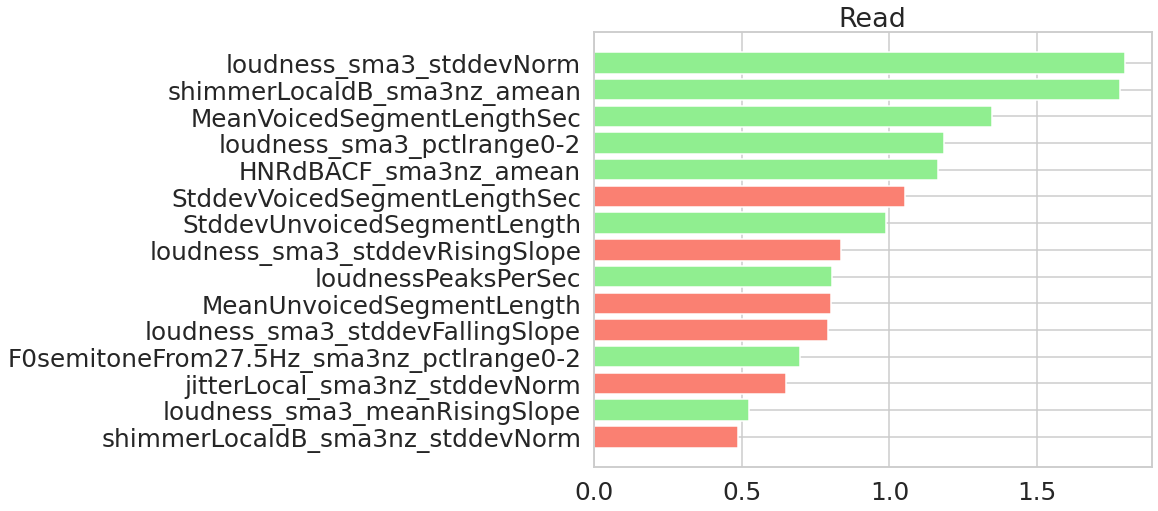

In [28]:
model.fit(df_gemaps_cgn[x_cols][::-1], df_gemaps_cgn["speech_style"][::-1])
plot_linear_classification_coefs(model, feat_cols=x_cols, nb_to_show=15)

/home/jonas/.cache/pypoetry/virtualenvs/gssp-27YL4uf1-py3.8/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


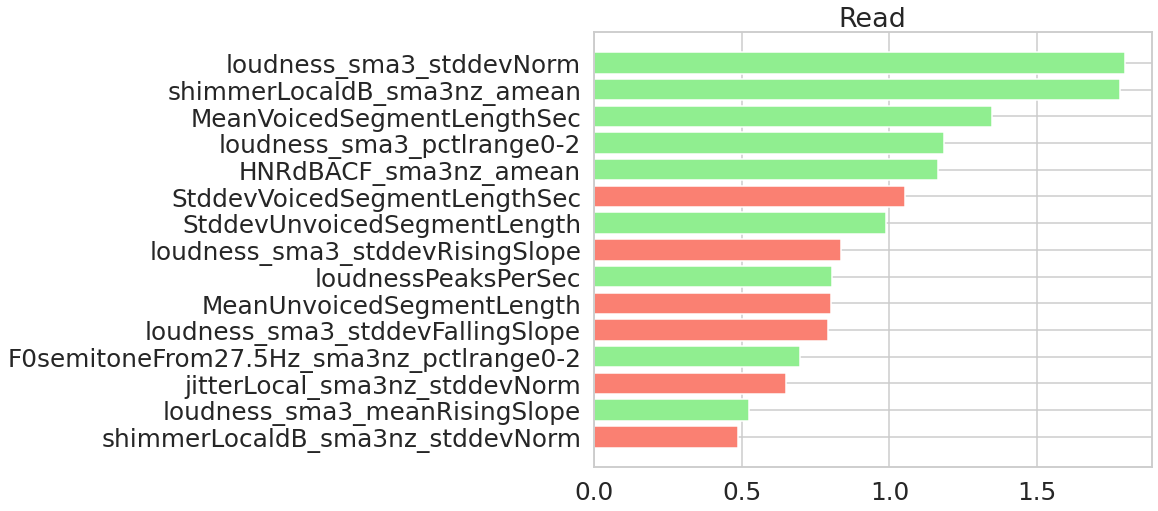

In [13]:
model.fit(df_gemaps_cgn[x_cols], df_gemaps_cgn["speech_style"])
plot_linear_classification_coefs(model, feat_cols=x_cols, nb_to_show=15)

In [14]:
df_gemaps_cgn["predictions"] = predictions
df_gemaps_cgn["misprediction"] = (
    df_gemaps_cgn["speech_style"] != df_gemaps_cgn["predictions"]
)
df_gemaps_cgn["n_segments"] = df_gemaps_cgn.groupby("speaker_name")[
    "speaker_name"
].transform(lambda x: len(x))
df_gemaps_cgn["n_mispredictions"] = df_gemaps_cgn.groupby("speaker_name")[
    "misprediction"
].transform(lambda x: x.sum())
df_gemaps_cgn["misprediction_ratio"] = (
    df_gemaps_cgn["n_mispredictions"] / df_gemaps_cgn["n_segments"]
)

<AxesSubplot:>

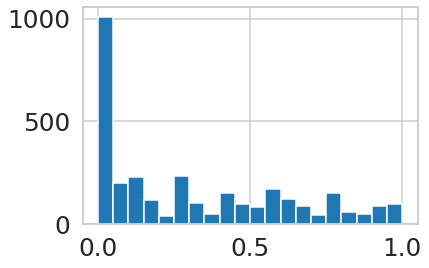

In [15]:
df_gemaps_cgn[(df_gemaps_cgn.n_segments > 5)]["misprediction_ratio"].hist(bins=20)

In [16]:
mispred_mask = (df_gemaps_cgn.n_segments > 10) & (
    df_gemaps_cgn["misprediction_ratio"] > 0.8
)
df_gemaps_cgn[mispred_mask].sort_values("misprediction_ratio", ascending=False).head(4)

,file,start,end,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,...,eduLevel,occupation,occLevel,component,speech_style,predictions,misprediction,n_segments,n_mispredictions,misprediction_ratio
index,,,,,,,,,,,,,,,,,,,,,
987,/media/SPS/cgn/cdroms/comp-b/vl/fv400111.wav,0 days 00:15:16.949000,0 days 00:15:31.949000,21.789574,0.116145,20.789738,21.886616,23.338650,2.548912,180.409851,...,edu1,leerkracht,occC,b,GSSP,Read,True,23,23,1.0
523,/media/SPS/cgn/cdroms/comp-b/vl/fv400127.wav,0 days 00:10:54.562000,0 days 00:11:09.562000,21.796476,0.132641,20.363504,22.091307,23.694054,3.330549,36.312397,...,edu1,leerkracht,occC,b,GSSP,Read,True,16,16,1.0
1001,/media/SPS/cgn/cdroms/comp-b/vl/fv400111.wav,0 days 00:21:14.751000,0 days 00:21:29.751000,24.874605,0.196631,21.515467,24.518528,28.317802,6.802336,177.382080,...,edu1,leerkracht,occC,b,GSSP,Read,True,23,23,1.0
529,/media/SPS/cgn/cdroms/comp-b/vl/fv400127.wav,0 days 00:16:03.839000,0 days 00:16:18.839000,22.454226,0.095414,21.109404,22.159269,23.647003,2.537600,99.683113,...,edu1,leerkracht,occC,b,GSSP,Read,True,16,16,1.0


In [17]:
df_gemaps_cgn[df_gemaps_cgn.misprediction == True].groupby(
    ["speaker_name", "speech_style", "misprediction"]
).size().sort_values(ascending=False)

speaker_name  speech_style  misprediction
V40110        GSSP          True             25
V40111        GSSP          True             23
V40167        GSSP          True             22
V40159        GSSP          True             22
V40157        GSSP          True             21
                                             ..
N00149        GSSP          True              1
V80058        Read          True              1
V80063        Read          True              1
V80019        Read          True              1
V80006        Read          True              1
Length: 165, dtype: int64